In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.decomposition import PCA
from yellowbrick.features import PCA
from yellowbrick.classifier import ClassificationReport, ROCAUC
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# for plot use
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray',
          'tab:olive','tab:cyan', 'c', 'm', 'y', 'r']

In [2]:
data = pd.read_csv("sample.csv")
data_Y = data[' Label']#.to_numpy().flatten()
data_X = data.drop(columns=['Unnamed: 0', 'Flow ID', ' Timestamp', ' Label'])
del data
gc.collect()

0

In [3]:
data_Y.value_counts()

TFTP       100000
BENIGN     100000
NTP        100000
NetBIOS    100000
SSDP       100000
MSSQL      100000
UDP        100000
DNS        100000
UDPLag     100000
Syn        100000
SNMP       100000
Portmap    100000
LDAP       100000
WebDDoS       439
Name:  Label, dtype: int64

### Feature Engineering

In [3]:
src_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Source IP']]
data_X[' Source IP'] = pd.Series(src_ip)

In [4]:
dst_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Destination IP']]
data_X[' Destination IP'] = pd.Series(dst_ip)

In [5]:
# do data_X['SimillarHTTP'].value_counts()
data_X['SimillarHTTP'][data_X['SimillarHTTP'] != 0] = 1      

In [6]:
# todo: scale before preprocessing
data_X['Flow Bytes/s'][np.isinf(data_X['Flow Bytes/s'])] = 9999999999
data_X['Flow Bytes/s'][data_X['Flow Bytes/s'].isna()] = data_X['Flow Bytes/s'].mean()

In [7]:
data_X[' Flow Packets/s'][np.isinf(data_X[' Flow Packets/s'])] = 5000000

### PCA

In [8]:
data_Y_num = data_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [9]:
labels = ['BENIGN', 'DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP',
               'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag', 'WebDDoS']

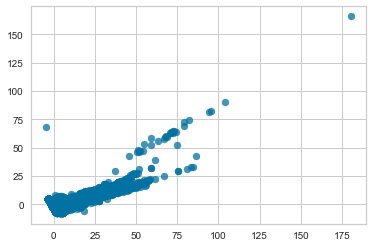

In [9]:
pca = PCA(n_components=2)
data_X_pca = pca.fit_transform(data_X)

In [10]:
data_X_pca[:5]

array([[-2.77630008,  4.50386267],
       [-1.98040137,  2.20505423],
       [-2.69884248,  4.47686262],
       [-2.52565847,  4.27083448],
       [-2.76824574,  4.50181562]])

## Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.3, random_state=1)

In [11]:
train_Y_num = train_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [12]:
test_Y_num = test_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [13]:
train_Y.value_counts()

MSSQL      70256
BENIGN     70205
DNS        70136
Syn        70087
Portmap    70063
UDP        70047
SNMP       70005
TFTP       70001
UDPLag     69979
NTP        69943
SSDP       69814
LDAP       69813
NetBIOS    69651
WebDDoS      307
Name:  Label, dtype: int64

In [14]:
test_Y.value_counts()

NetBIOS    30349
LDAP       30187
SSDP       30186
NTP        30057
UDPLag     30021
TFTP       29999
SNMP       29995
UDP        29953
Portmap    29937
Syn        29913
DNS        29864
BENIGN     29795
MSSQL      29744
WebDDoS      132
Name:  Label, dtype: int64

## Standardizer

In [18]:
scaler = StandardScaler().fit(train_X)
train_X_std = scaler.transform(train_X)
test_X_std = scaler.transform(test_X)

## Feature Importance - Random Forest

In [38]:
rf = RandomForestClassifier(criterion='gini', n_estimators=1000, random_state=0, n_jobs=-1).fit(train_X_std, train_Y_num)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

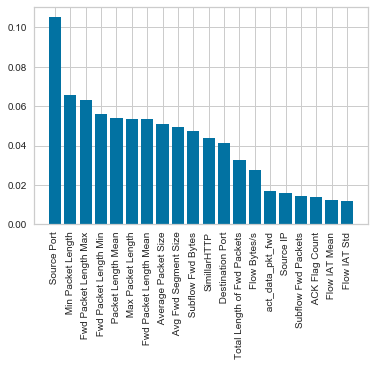

In [22]:
names = [data_X.columns[i] for i in indices]
plt.figure()
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), names[:20], rotation=90)
plt.show()

In [17]:
randomforest.score(train_X_std, train_Y)

0.8574298481954647

In [18]:
randomforest.score(test_X_std, test_Y)

0.7927163114022946

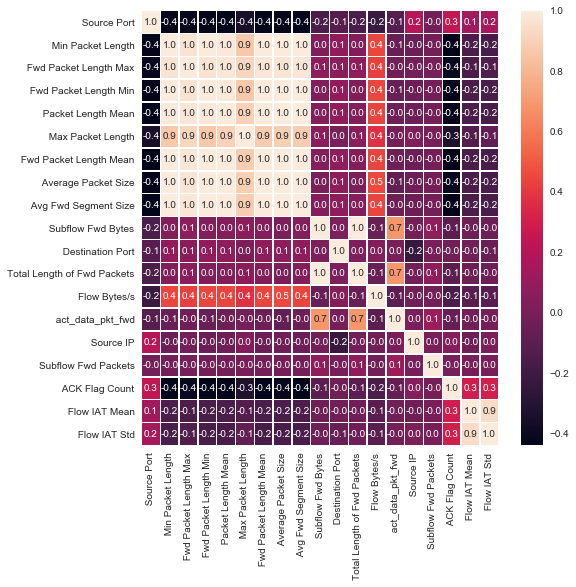

In [30]:
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(data_X[names[:20]].corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

## Training

### Logistic Regression

In [33]:
params = np.logspace(-3,4,15)
train_err = []
test_err = []

In [34]:
for c in params:
    logit = LogisticRegression(C=c, random_state=0, n_jobs=-1).fit(train_X_std, train_Y_num)
    train_err.append(1-logit.score(train_X_std, train_Y_num))
    test_err.append(1-logit.score(test_X_std, test_Y_num))

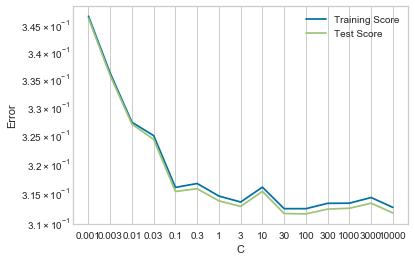

In [35]:
plt.semilogy(range(1,16), train_err, label="Training Score")
plt.semilogy(range(1,16), test_err, label="Test Score")

plt.xticks(range(1,16),[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000])
plt.xlabel("C")
plt.ylabel("Error")
plt.legend()
plt.show()

In [27]:
lrcv = LogisticRegressionCV(Cs=100, random_state=0, n_jobs=-1).fit(train_X_std, train_Y_num)

In [28]:
lrcv

LogisticRegressionCV(Cs=100, n_jobs=-1, random_state=0)

In [29]:
lrcv.C_

array([0.14174742, 0.14174742, 0.14174742, 0.14174742, 0.14174742,
       0.14174742, 0.14174742, 0.14174742, 0.14174742, 0.14174742,
       0.14174742, 0.14174742, 0.14174742, 0.14174742])

In [30]:
lrcv.score(train_X_std, train_Y_num)

0.6938834920526812

In [31]:
lrcv.score(test_X_std, test_Y_num)

0.694780228230445

In [32]:
test_Yhat = lrcv.predict(test_X_std)
cm = confusion_matrix(test_Y_num, test_Yhat)

Precision, Recall, F1

In [33]:
m_pr, m_rec, m_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='macro')
w_pr, w_rec, w_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='weighted')
print("\t\t\tMacro\t\tWeightened")
print("Precision:\t", m_pr, w_pr)
print("Recall:\t\t", m_rec, w_rec)
print("F1:\t\t", m_f1, w_f1)

			Macro		Weightened
Precision:	 0.7215930405208596 0.7248701105366141
Recall:		 0.6577396223078844 0.694780228230445
F1:		 0.6490605227512912 0.6773976662946553


Confusion Matrix

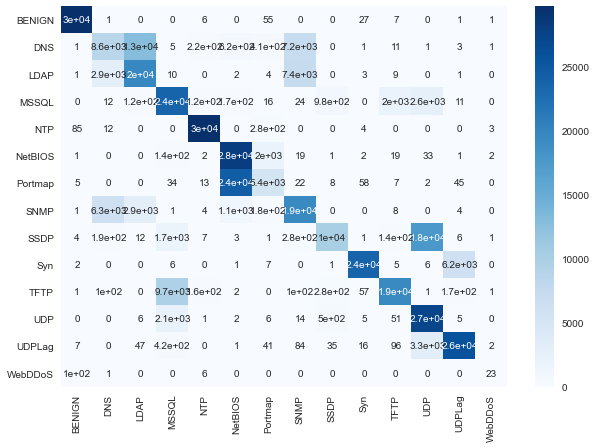

In [34]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', linecolor='white')

Classification Report

In [35]:
print(classification_report(test_Y_num, test_Yhat, target_names=labels))

              precision    recall  f1-score   support

      BENIGN       0.99      1.00      0.99     29795
         DNS       0.47      0.29      0.36     29864
        LDAP       0.55      0.66      0.60     30187
       MSSQL       0.63      0.80      0.70     29744
         NTP       0.98      0.99      0.98     30057
     NetBIOS       0.52      0.93      0.66     30349
     Portmap       0.64      0.18      0.28     29937
        SNMP       0.56      0.65      0.60     29995
        SSDP       0.85      0.34      0.48     30186
         Syn       0.99      0.79      0.88     29913
        TFTP       0.89      0.65      0.75     29999
         UDP       0.54      0.91      0.67     29953
      UDPLag       0.80      0.86      0.83     30021
     WebDDoS       0.68      0.17      0.28       132

    accuracy                           0.69    390132
   macro avg       0.72      0.66      0.65    390132
weighted avg       0.72      0.69      0.68    390132



### Random Forest

In [39]:
rf.score(train_X_std, train_Y_num)

0.857571127103274

In [40]:
rf.score(test_X_std, test_Y_num)

0.7930290260732265

In [41]:
test_Yhat = rf.predict(test_X_std)
cm = confusion_matrix(test_Y_num, test_Yhat)

Precision, Recall, F1

In [42]:
m_pr, m_rec, m_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='macro')
w_pr, w_rec, w_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='weighted')
print("\t\t\tMacro\t\tWeightened")
print("Precision:\t", m_pr, w_pr)
print("Recall:\t\t", m_rec, w_rec)
print("F1:\t\t", m_f1, w_f1)

			Macro		Weightened
Precision:	 0.8015136356654137 0.8091212431135534
Recall:		 0.7875433682241245 0.7930290260732265
F1:		 0.7828102693515218 0.7884404590703591


Confusion Matrix

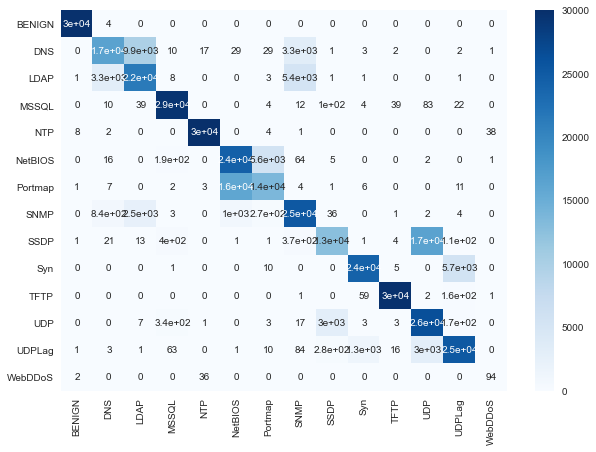

In [43]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', linecolor='white')

Classification Report

In [44]:
print(classification_report(test_Y_num, test_Yhat, target_names=labels))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     29795
         DNS       0.80      0.55      0.65     29864
        LDAP       0.63      0.71      0.67     30187
       MSSQL       0.97      0.99      0.98     29744
         NTP       1.00      1.00      1.00     30057
     NetBIOS       0.59      0.81      0.68     30349
     Portmap       0.70      0.46      0.56     29937
        SNMP       0.73      0.85      0.78     29995
        SSDP       0.79      0.42      0.55     30186
         Syn       0.94      0.81      0.87     29913
        TFTP       1.00      0.99      1.00     29999
         UDP       0.57      0.88      0.70     29953
      UDPLag       0.80      0.84      0.82     30021
     WebDDoS       0.70      0.71      0.70       132

    accuracy                           0.79    390132
   macro avg       0.80      0.79      0.78    390132
weighted avg       0.81      0.79      0.79    390132



### NN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [16]:
train_X.shape

(910307, 84)

In [19]:
nn = Sequential()
nn.add(Dense(84, activation='relu', input_shape=(84,)))
nn.add(Dropout(0.2))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(14, activation='softmax'))
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], 
            validation_data=(test_X_std, test_Y_num))

In [21]:
history = nn.fit(x=train_X_std, y=train_Y_num, epochs=100, batch_size=1500)

Train on 910307 samples
Epoch 1/100
910307/910307 [==============================] - 19s 21us/sample - loss: 0.8611 - accuracy: 0.6309
Epoch 2/100
910307/910307 [==============================] - 19s 21us/sample - loss: 0.6619 - accuracy: 0.6935
Epoch 3/100
910307/910307 [==============================] - 19s 21us/sample - loss: 0.6214 - accuracy: 0.7087
Epoch 4/100
910307/910307 [==============================] - 19s 21us/sample - loss: 0.5962 - accuracy: 0.7189
Epoch 5/100
910307/910307 [==============================] - 19s 21us/sample - loss: 0.5818 - accuracy: 0.7278
Epoch 6/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5646 - accuracy: 0.7411
Epoch 7/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5501 - accuracy: 0.7486
Epoch 8/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5413 - accuracy: 0.7519
Epoch 9/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5

910307/910307 [==============================] - 18s 19us/sample - loss: 0.5023 - accuracy: 0.7638
Epoch 75/100
910307/910307 [==============================] - 18s 19us/sample - loss: 0.5021 - accuracy: 0.7645
Epoch 76/100
910307/910307 [==============================] - 18s 19us/sample - loss: 0.5027 - accuracy: 0.7639
Epoch 77/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5022 - accuracy: 0.7640
Epoch 78/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5022 - accuracy: 0.7641
Epoch 79/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5020 - accuracy: 0.7641
Epoch 80/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5031 - accuracy: 0.7635
Epoch 81/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5032 - accuracy: 0.7636
Epoch 82/100
910307/910307 [==============================] - 18s 20us/sample - loss: 0.5028 - accuracy: 0.7633
Epoch

In [22]:
nn.save('nn_model_100.h5')

In [23]:
nn.evaluate(test_X_std, test_Y_num)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.48816781942821386, 0.7661817]

In [26]:
test_Yhat = nn.predict_classes(test_X_std)
cm = confusion_matrix(test_Y_num, test_Yhat)

Precision, Recall, F1

In [27]:
m_pr, m_rec, m_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='macro')
w_pr, w_rec, w_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='weighted')
print("\t\t\tMacro\t\tWeightened")
print("Precision:\t", m_pr, w_pr)
print("Recall:\t\t", m_rec, w_rec)
print("F1:\t\t", m_f1, w_f1)

			Macro		Weightened
Precision:	 0.7819421187541472 0.7945828540179938
Recall:		 0.781465384239845 0.7661817026032215
F1:		 0.7544617587083172 0.7540444494237694


Confusion Matrix

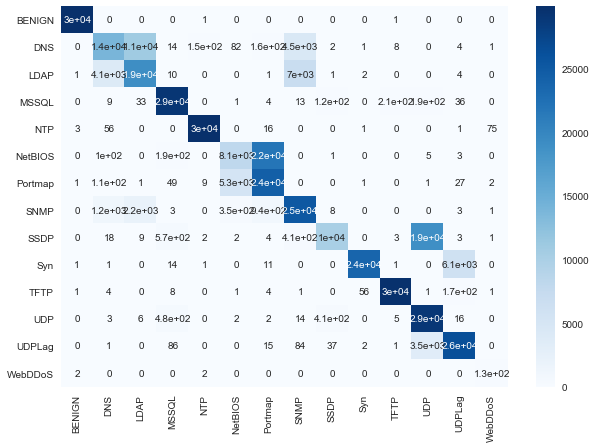

In [28]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', linecolor='white')

Classification Report

In [29]:
print(classification_report(test_Y_num, test_Yhat, target_names=labels))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     29795
         DNS       0.72      0.47      0.56     29864
        LDAP       0.59      0.63      0.61     30187
       MSSQL       0.95      0.98      0.97     29744
         NTP       0.99      0.99      0.99     30057
     NetBIOS       0.59      0.27      0.37     30349
     Portmap       0.51      0.82      0.63     29937
        SNMP       0.68      0.84      0.75     29995
        SSDP       0.95      0.34      0.50     30186
         Syn       1.00      0.79      0.88     29913
        TFTP       0.99      0.99      0.99     29999
         UDP       0.56      0.97      0.71     29953
      UDPLag       0.80      0.88      0.84     30021
     WebDDoS       0.61      0.97      0.75       132

    accuracy                           0.77    390132
   macro avg       0.78      0.78      0.75    390132
weighted avg       0.79      0.77      0.75    390132



Loss, Accuracy / Epochs

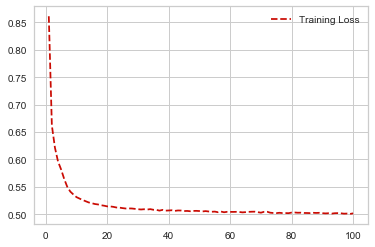

In [30]:
training_loss = history.history['loss']
#test_loss = history.history['accuracy']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])

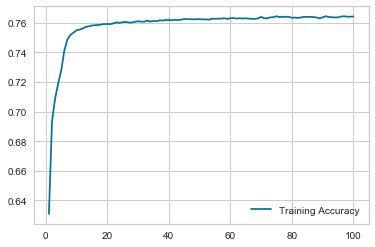

In [31]:
#training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
epoch_count = range(1, len(training_loss) + 1)
#plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_accuracy, 'b-')
plt.legend(['Training Accuracy'])

In [1]:
from keras.models import load_model
network = load_model('nn_model_100.h5')

Using TensorFlow backend.


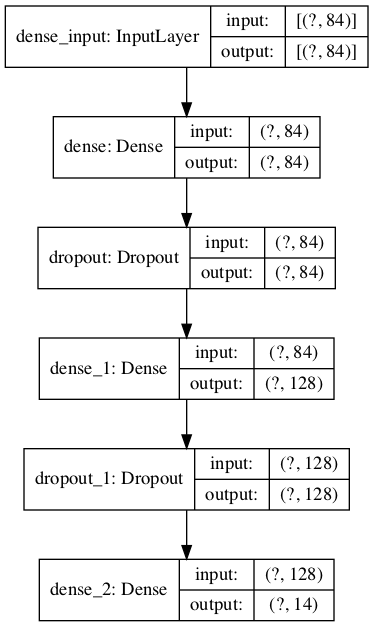

In [22]:
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import  plot_model
from IPython.display import SVG
plot_model(nn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 84)                7140      
_________________________________________________________________
dropout_2 (Dropout)          (None, 84)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               10880     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 14)                1806      
Total params: 19,826
Trainable params: 19,826
Non-trainable params: 0
_________________________________________________________________
